In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Input, Lambda, Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, Sequential, load_model
import keras.backend as K
import tensorflow.keras as keras

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
import pandas as pd 
import numpy as np
import re
import random
import math
from bs4 import BeautifulSoup

In [3]:
tf.test.gpu_device_name() 

'/device:GPU:0'

In [12]:
print(tf.__version__)

1.15.2


In [4]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv


In [5]:
spamTexts = pd.read_csv('spam.csv', engine='python')
print(spamTexts.shape)

(5572, 5)


In [0]:
def denoise_text(text):    
    # Remove the html strips
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    
    # Remove digits and punctuations 
    pattern=r'[^a-zA-Z]'
    text=re.sub(pattern,' ',text)
    
    # Remove single characters
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
        
    return text

In [0]:
clean_texts = []
sentences = list(spamTexts['v2'])
for sen in sentences:
    clean_texts.append(denoise_text(sen))

In [0]:
y = spamTexts['v1']

y = np.array(list(map(lambda x: 1 if x=="spam" else 0, y)))

In [0]:
clean_texts_with_y = [[txt, y[i]] for i, txt in enumerate(clean_texts)]
random.shuffle(clean_texts_with_y)

In [11]:
train_X ,train_Y, test_X, test_Y = [], [], [], []

train_size = math.ceil(len(clean_texts_with_y)*0.8)

for e in clean_texts_with_y[:train_size]:
    train_X.append(e[0])
    train_Y.append(e[1])

for e in clean_texts_with_y[train_size:]:
    test_X.append(e[0])
    test_Y.append(e[1])
    
print("train_size:",len(train_X))
print("test_size:",len(test_X))

train_size: 4458
test_size: 1114


In [0]:
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

In [0]:
embeddings = elmo(
["the cat is on the mat", "what are you doing in evening"],
signature="default",
as_dict=True)["elmo"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:

#embed = hub.Module("https://tfhub.dev/google/elmo/3")
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [0]:
def build_model(): 
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    dense = Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002), metrics=['accuracy'])
    return model

In [46]:
model_elmo = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [17]:
model_elmo.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 1,050,625
Trainable params: 1,050,625
Non-trainable params: 0
_________________________________________________________________


In [47]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model_elmo.fit(np.array(train_X), np.array(train_Y), epochs=10, batch_size=32, validation_split = 0.2)
    model_elmo.save_weights('./model_spam_elmo.h5')

Train on 3566 samples, validate on 892 samples
Epoch 1/10
3566/3566 [==============================] - 26s 7ms/sample - loss: 1.0045 - acc: 0.9481 - val_loss: 0.7867 - val_acc: 0.9720
Epoch 2/10
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.6425 - acc: 0.9787 - val_loss: 0.5381 - val_acc: 0.9809
Epoch 3/10
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.4480 - acc: 0.9826 - val_loss: 0.4001 - val_acc: 0.9731
Epoch 4/10
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.3322 - acc: 0.9860 - val_loss: 0.3075 - val_acc: 0.9798
Epoch 5/10
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.2525 - acc: 0.9871 - val_loss: 0.2349 - val_acc: 0.9877
Epoch 6/10
3566/3566 [==============================] - 24s 7ms/sample - loss: 0.1972 - acc: 0.9910 - val_loss: 0.1897 - val_acc: 0.9877
Epoch 7/10
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.1586 - acc: 0.9907 - val_loss: 0.1593 - val_acc: 0

In [48]:
history.history['loss']

[1.004508259954308,
 0.6424541151797711,
 0.4479754459837883,
 0.3321980609863044,
 0.2525289627319631,
 0.19722523224768315,
 0.15864400519658792,
 0.13100759681696578,
 0.10900593726606898,
 0.10001377187213802]

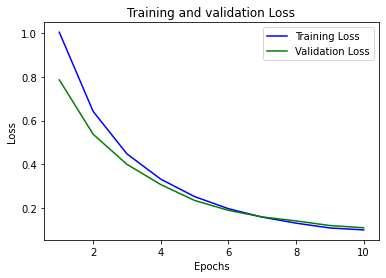

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

#acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_elmo.load_weights('./model_spam_elmo.h5')
    predicts = model_elmo.predict(np.array(test_X))


In [76]:
len(predicts)

1114

In [0]:
pred_Y=[]
for i in range(len(predicts)):
    if predicts[i] >= 0.5:
        pred_Y.append(1)
    else:
        pred_Y.append(0)      

In [0]:
res = []
for i in range(len(test_Y)):
    res.append([test_Y[i],pred_Y[i]])


In [0]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
fpr, tpr, thresholds = roc_curve(test_Y, pred_Y)
auc(fpr, tpr)

0.9529829545454546

In [58]:

print("precision : ", precision_score(test_Y, pred_Y, average="micro"))
print("recall : ", recall_score(test_Y, pred_Y, average="micro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="micro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))
#print(confusion_matrix(test_Y, pred_Y))

precision :  0.9847396768402155
recall :  0.9847396768402155
f1_score :  0.9847396768402155
accuracy_score :  0.9847396768402155


In [59]:
print("precision : ", precision_score(test_Y, pred_Y, average="macro"))
print("recall : ", recall_score(test_Y, pred_Y, average="macro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="macro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))

precision :  0.9823014266886564
recall :  0.9529829545454545
f1_score :  0.9669786070614657
accuracy_score :  0.9847396768402155


In [62]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_elmo.load_weights('./model_spam_elmo.h5')
    history = model_elmo.fit(np.array(train_X), np.array(train_Y), epochs=10, batch_size=32, validation_split = 0.2)
    model_elmo.save_weights('./model_spam_elmo.h5')

Train on 3566 samples, validate on 892 samples
Epoch 1/10
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.0865 - acc: 0.9921 - val_loss: 0.1016 - val_acc: 0.9832
Epoch 2/10
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.0707 - acc: 0.9933 - val_loss: 0.0914 - val_acc: 0.9821
Epoch 3/10
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.0671 - acc: 0.9933 - val_loss: 0.0851 - val_acc: 0.9843
Epoch 4/10
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.0585 - acc: 0.9947 - val_loss: 0.0786 - val_acc: 0.9877
Epoch 5/10
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.0560 - acc: 0.9936 - val_loss: 0.0868 - val_acc: 0.9843
Epoch 6/10
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.0524 - acc: 0.9938 - val_loss: 0.0992 - val_acc: 0.9776
Epoch 7/10
3566/3566 [==============================] - 24s 7ms/sample - loss: 0.0626 - acc: 0.9907 - val_loss: 0.0792 - val_acc: 0

In [63]:
history.history['loss']

[0.08651072831549673,
 0.07066502865451946,
 0.06712863013875398,
 0.058463993274924866,
 0.055979916091488106,
 0.05235330233129971,
 0.06258024144510306,
 0.04553197110954524,
 0.03998809044348077,
 0.04066033759773346]

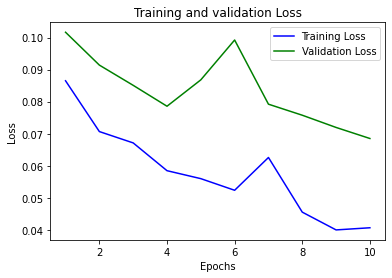

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

#acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [69]:
fpr, tpr, thresholds = roc_curve(test_Y, pred_Y)
auc(fpr, tpr)

0.975189393939394

In [70]:

print("precision : ", precision_score(test_Y, pred_Y, average="micro"))
print("recall : ", recall_score(test_Y, pred_Y, average="micro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="micro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))
#print(confusion_matrix(test_Y, pred_Y))

precision :  0.9901256732495511
recall :  0.9901256732495511
f1_score :  0.9901256732495511
accuracy_score :  0.9901256732495511


In [71]:
print("precision : ", precision_score(test_Y, pred_Y, average="macro"))
print("recall : ", recall_score(test_Y, pred_Y, average="macro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="macro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))

precision :  0.9831204912903249
recall :  0.975189393939394
f1_score :  0.979107098710178
accuracy_score :  0.9901256732495511


In [72]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_elmo.load_weights('./model_spam_elmo.h5')
    history = model_elmo.fit(np.array(train_X), np.array(train_Y), epochs=30, batch_size=32, validation_split = 0.2)
    model_elmo.save_weights('./model_spam_elmo.h5')

Train on 3566 samples, validate on 892 samples
Epoch 1/30
3566/3566 [==============================] - 26s 7ms/sample - loss: 0.0416 - acc: 0.9955 - val_loss: 0.0871 - val_acc: 0.9821
Epoch 2/30
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.0409 - acc: 0.9961 - val_loss: 0.0662 - val_acc: 0.9821
Epoch 3/30
3566/3566 [==============================] - 24s 7ms/sample - loss: 0.0344 - acc: 0.9975 - val_loss: 0.0629 - val_acc: 0.9877
Epoch 4/30
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.0353 - acc: 0.9978 - val_loss: 0.0632 - val_acc: 0.9888
Epoch 5/30
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.0364 - acc: 0.9966 - val_loss: 0.0723 - val_acc: 0.9821
Epoch 6/30
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.0333 - acc: 0.9969 - val_loss: 0.0706 - val_acc: 0.9865
Epoch 7/30
3566/3566 [==============================] - 25s 7ms/sample - loss: 0.0352 - acc: 0.9964 - val_loss: 0.0745 - val_acc: 0

In [73]:
history.history['loss']

[0.041617087539300046,
 0.04085537761165664,
 0.034388890988243076,
 0.03531960908593051,
 0.03641316936096982,
 0.03331838904415632,
 0.035220123839993456,
 0.03828122516110982,
 0.03227278708667817,
 0.03742057204338452,
 0.0319195526202308,
 0.029381655526425285,
 0.03171968266714743,
 0.03361554827647669,
 0.028475037470368007,
 0.026701121830783128,
 0.029043971274133752,
 0.027197225828954362,
 0.027200685761789557,
 0.026108325268410927,
 0.02406029560327931,
 0.031210485472857315,
 0.03719688573381036,
 0.031900102252781025,
 0.025426549660444126,
 0.02373083142654587,
 0.024186576518637037,
 0.024767176029797323,
 0.02720195304474935,
 0.03156501382789917]

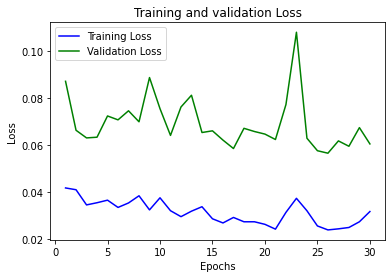

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

#acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [79]:
fpr, tpr, thresholds = roc_curve(test_Y, pred_Y)
auc(fpr, tpr)

0.9562297077922078

In [80]:
print("precision : ", precision_score(test_Y, pred_Y, average="micro"))
print("recall : ", recall_score(test_Y, pred_Y, average="micro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="micro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))
#print(confusion_matrix(test_Y, pred_Y))

precision :  0.9856373429084381
recall :  0.9856373429084381
f1_score :  0.9856373429084381
accuracy_score :  0.9856373429084381


In [81]:
print("precision : ", precision_score(test_Y, pred_Y, average="macro"))
print("recall : ", recall_score(test_Y, pred_Y, average="macro")) 
print("f1_score : ", f1_score(test_Y, pred_Y, average="macro"))
print("accuracy_score : ", accuracy_score(test_Y, pred_Y))

precision :  0.9828823024054982
recall :  0.9562297077922077
f1_score :  0.9690092846959002
accuracy_score :  0.9856373429084381
